### Method of Multiplier Proximal Maps for 2-Player Control-Disturbance Games

In [1]:
using LinearAlgebra, Plots 
using TickTock, Suppressor

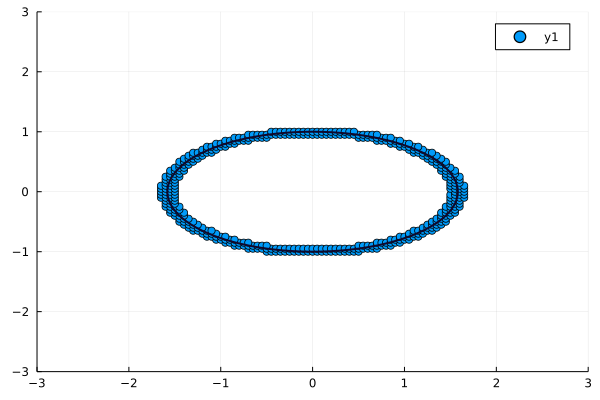

In [2]:
ϵ = 0.5e-9 
N = 20 + ϵ
xig = collect(-3:1/N:3)
Xg = hcat(collect.(Iterators.product(xig .- ϵ, xig .+ ϵ))...)[:,:] #[end:-1:1,:]

th = 0.05; 
tg = [th:th:3.]

A = diagm([2.5, 1])
J(X, A) = 0.5*diag(X' * inv(A) * X) .- 0.5
ϕ = J(Xg, A)

scatter(Xg[1, abs.(ϕ) .< 0.05], Xg[2, abs.(ϕ) .< 0.05], xlims=[-3,3], ylims=[-3,3])
contour!(xig, xig, ϕ, levels=[0], colorbar=false, lw=2)

In [3]:
### Shrink Operators for Proximal Update of Convex Player

## Simple Newton Method specifically for Ellipses from DO 2016
function shrink_NM_scalar(w, A; tol=0.5e-9)

    μ, μ_old = 1, 0

    while abs(μ - μ_old) > tol

        μ_old = μ
        μ = μ - (1 - sum((A * w.^2) ./ (diag(A) .+ μ).^2)) / (2 * sum((A * w.^2) ./ (diag(A) .+ μ).^3))

    end

    return (A * w) ./ (diag(A) .+ μ)
end

## Bisection Method specifically for Ellipses from GTools 2013
function shrink_BM_scalar(w, A; tol=0.5e-9)

    amin, imin = minimum(diag(A)), argmin(diag(A))
    μ0, μ1 = -amin + sqrt(amin) * w[imin], -amin + sqrt(sum(A * w.^2))

    while abs(μ0 - μ1) > tol

        μ = (μ0 + μ1)/2

        μ0, μ1 = sum((A * w.^2) ./ (diag(A) .+ μ).^2) - 1  > 0 ? (μ, μ1) : (μ0, μ)

    end

    return (A * w) ./ (diag(A) .+ (μ0 + μ1)/2)
end

shrink_BM_scalar (generic function with 1 method)

┌ Info:  started timer at: 2022-10-25T15:48:54.762
└ @ TickTock /Users/willsharpless/.julia/packages/TickTock/fGILW/src/TickTock.jl:54


NM: 0.24499625 seconds


BM: 0.000414917 seconds


┌ Info:  started timer at: 2022-10-25T15:48:55.126
└ @ TickTock /Users/willsharpless/.julia/packages/TickTock/fGILW/src/TickTock.jl:54


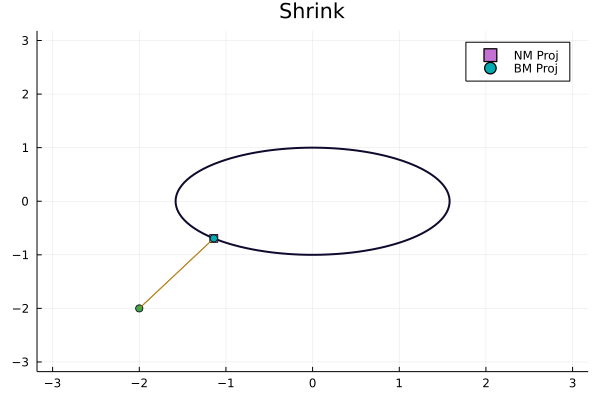

In [4]:
## Shrink Test (Scalar)

w = [-2., -2.] # outside test
# w = [-0.5, -0.5] # inside test

tick()
πCw = shrink_BM_scalar(w, A)
println("NM: ", tok(), " seconds");

contour(xig, xig, ϕ, levels=[0], colorbar=false, lw=2)
plot!([w[1], πCw[1]], [w[2], πCw[2]], label="")
scatter!([w[1]], [w[2]], label="")
scatter!([πCw[1]], [πCw[2]], shape=:square, label="NM Proj")

tick()
πCw = shrink_BM_scalar(w, A)
println("BM: ", tok(), " seconds");

# scatter(Xg[1, abs.(ϕ) .< 0.05], Xg[2, abs.(ϕ) .< 0.05])
plot!([w[1], πCw[1]], [w[2], πCw[2]], label="")
# scatter!([w[1]], [w[2]], label="")
scatter!([πCw[1]], [πCw[2]], label="BM Proj")
title!("Shrink")

# contour!(xig, xig, map(norm, eachcol(w .- Xg)), levels=collect(1.51:0.005:1.65), color=:glasbey_hv_n256, xlims=[-1.25, -1], ylims= [-0.75, -0.6])

In [5]:
### Shrink Operators for Proximal Update of Convex Player (Vectorized)

## Simple Newton Method specifically for Ellipses from DO 2016
function shrink_NM(Wi, A; tol=0.5e-9, ϵ=1e-3)

    Wo = copy(Wi); 
    mask = map(w -> ((w' * inv(A) * w) > 1), eachcol(Wo)); # select points outside
    if sum(mask) == 0; return Wo; end
    W = view(Wo, :, mask)

    W[abs.(W) .< ϵ] = W[abs.(W) .< ϵ] .+ (ϵ * sign.(W[abs.(W) .< ϵ] .+ tol)) # for zeros-robustness

    μ, μ_old = ones(1, size(W)[2]), zeros(1, size(W)[2])

    while maximum(abs.(μ - μ_old)) > tol

        μ_old = μ
        μ = μ .- (1 .- sum((A * W.^2) ./ (diag(A) .+ μ).^2, dims=1)) ./ (2 * sum((A * W.^2) ./ (diag(A) .+ μ).^3, dims=1))

    end

    Wo[:, mask] = (A * W) ./ (diag(A) .+ μ)

    return Wo
end

# ## Bisection Method specifically for Ellipses from GTools 2013
function shrink_BM(Wi, A; tol=0.5e-9, ϵ=1e-3)

    Wo = copy(Wi); 
    mask = map(w -> ((w' * inv(A) * w) > 1), eachcol(Wo)); # select points outside
    if sum(mask) == 0; return Wo; end
    W = view(Wo, :, mask)

    W[abs.(W) .< ϵ] = W[abs.(W) .< ϵ] .+ (ϵ * sign.(W[abs.(W) .< ϵ] .+ tol)) # for zeros-robustness

    amin, imin = minimum(diag(A)), argmin(diag(A))
    μ0 = -amin .+ sqrt(amin) * W[imin,:]' 
    μ1 = -amin .+ sqrt.(sum(A * W.^2, dims = 1))

    while minimum(abs.(μ0 - μ1)) > tol

        μ = (μ0 + μ1)/2

        ix = sum((A * W.^2) ./ (diag(A) .+ μ).^2, dims=1) .- 1 .> 0 
        μ0[ix], μ1[.!ix] = μ[ix], μ[.!ix]

    end

    Wo[:, mask] = (A * W) ./ (diag(A) .+ (μ0 + μ1)/2)

    return Wo
end

shrink_BM (generic function with 1 method)

NM: Shrink took 0.000493584 seconds
BM: Shrink took 0.007294791 seconds


┌ Info:  started timer at: 2022-10-25T15:49:34.547
└ @ TickTock /Users/willsharpless/.julia/packages/TickTock/fGILW/src/TickTock.jl:54
┌ Info:  started timer at: 2022-10-25T15:49:34.568
└ @ TickTock /Users/willsharpless/.julia/packages/TickTock/fGILW/src/TickTock.jl:54


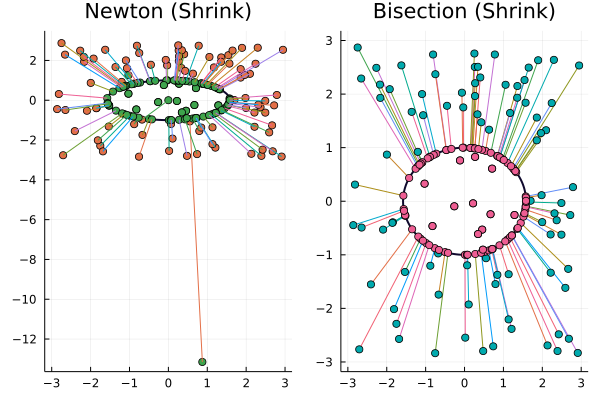

In [17]:
## Shrink Test (Vectorized)

W = 6*rand(2,100) .- [3.; 3]

A = diagm([2.5, 1])
# W = W[:, J(W, A) .< -0.1] # (outside J)
# W = W[:, abs.(J(W, A)) .> 0.1]  # (away from ∂J)

## Newton Method

p1 = contour(xig, xig, ϕ, levels=[0], colorbar=false, lw=2, legend=false)

tick()
πCW = shrink_NM(W, A)
println("NM: Shrink took ", tok(), " seconds");

scatter!(W[1,:], W[2,:])
scatter!(πCW[1,:], πCW[2,:])

for i = 1:size(W)[2]
    plot!([W[1,i], πCW[1,i]], [W[2,i], πCW[2,i]], label="")
end
title!("Newton (Shrink)") 

## Bisection Method 

tick()
πCW = shrink_BM(W, A)
println("BM: Shrink took ", tok(), " seconds");

p2 = contour(xig, xig, ϕ, levels=[0], colorbar=false, lw=2, legend=false)
for i = 1:size(W)[2]
    plot!([W[1,i], πCW[1,i]], [W[2,i], πCW[2,i]], label="")
end
scatter!(W[1,:], W[2,:])
scatter!(πCW[1,:], πCW[2,:])
title!("Bisection (Shrink)") 

plot(p1, p2)

One way we could compute the stretch is to project the boundary of the control set onto a tiny sphere around the point and find point that maximizes the distance. This isn't completely vectorizeable (unless we used tensor math? mu would be a matrix), but it still might be fast enough. -Wait this is equivalent to shifting the system and taking the norm

Alternatively, the general way to solve this is by reformulating it as a HJE of the 2 norm with the target set initially being the boundary of the c/d set. This can be solved with a mini ADMM problem that is vectorizeable. The problem with this method, is that we might find multiple points with different reruns of the opt given the concave nature of the problem.

In [7]:
## Stretch Operator for Proximal Update of Concave Player

## ADMM General Convex Set Method
function stretch_ADMM_scalar(w, A; tol=0.5e-9)

    σ, max_its, k = 2, 100, 0
    p, q , η, p_old = zeros(length(w)), zeros(length(w)), zeros(length(w)), ones(length(w))
    
    while norm(p - p_old) > tol

        p_old = copy(p)

        if norm(q - η - w) > 1e-3
            p = w + 0.5 * (q - η + w) * (1 + sqrt(1 + 4 / (σ * norm(q - η + w)^2)))
        else
            p = zeros(length(w))
        end
        
        q = shrink_NM_scalar(η + p, A)
        η = η - q + p

        if k == max_its
            σ, k = 4*σ, 0
            p, q , η, p_old = ones(length(w)), zeros(length(w)), zeros(length(w)), zeros(length(w))
        else
            k = k+1
        end
    end

    return -p
end

## Bisection Method specifically for Ellipses WAS, adapted from GTools 2013
function stretch_BM_scalar(w, A; tol=0.5e-9)

    amin, imin = maximum(diag(A)), argmax(diag(A))
    μ0, μ1 = -amin - sqrt(amin) * w[imin], -amin - sqrt(sum(A * w.^2))

    while abs(μ0 - μ1) > tol

        μ = (μ0 + μ1)/2

        μ0, μ1 = sum((A * w.^2) ./ (diag(A) .+ μ).^2) - 1  > 0 ? (μ, μ1) : (μ0, μ) #shrink 

    end

    return (A * w) ./ (diag(A) .+ (μ0 + μ1)/2)
end

stretch_BM_scalar (generic function with 1 method)

┌ Info:  started timer at: 2022-10-25T15:48:58.428
└ @ TickTock /Users/willsharpless/.julia/packages/TickTock/fGILW/src/TickTock.jl:54


sub-ADMM: Stretch took 0.306920375 seconds
BM: Stretch took 0.058991625 seconds


┌ Info:  started timer at: 2022-10-25T15:48:58.737
└ @ TickTock /Users/willsharpless/.julia/packages/TickTock/fGILW/src/TickTock.jl:54


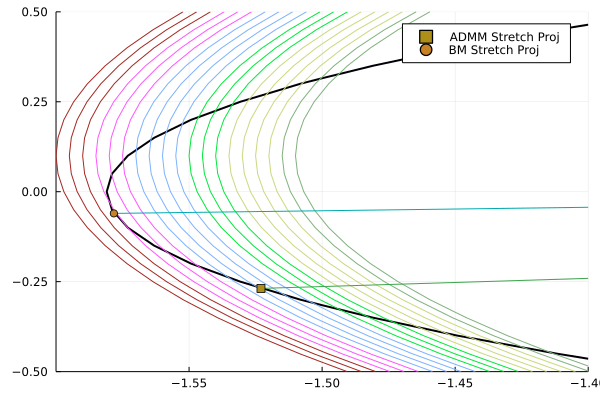

In [8]:
## Stretch Test (Scalar)

A = diagm([2.5, 1.])
ϕ = J(Xg, A)

w = [0.1; 0.1]
p1 = contour(xig, xig, ϕ/10, levels=[0], lw=2, xlims=[-1.5, 1.5], ylims= [-1, 1], colorbar=false)
contour!(xig, xig, map(norm, eachcol(w .- Xg)), levels=collect(1.61:0.005:1.7), color=:glasbey_hv_n256, xlims=[-1.6, -1.4], ylims= [-0.5, 0.5])

tick()
πCw = stretch_ADMM_scalar(w, A)
println("sub-ADMM: Stretch took ", tok(), " seconds");

plot!([w[1], πCw[1]], [w[2], πCw[2]], label = "")
scatter!([w[1]], [w[2]], label= "")
scatter!([πCw[1]], [πCw[2]], shape=:square, label="ADMM Stretch Proj")

tick()
πCw = stretch_BM_scalar(w, A)
println("BM: Stretch took ", tok(), " seconds");

plot!([w[1], πCw[1]], [w[2], πCw[2]], label="")
scatter!([w[1]], [w[2]], label="")
scatter!([πCw[1]], [πCw[2]], label="BM Stretch Proj")

In [9]:
## Stretch Operator for Proximal Update of Concavtiy

## ADMM Method Proposed by CDO 2017
function stretch_ADMM(Wi, A; tol=0.5e-9)

    Wo = copy(Wi); 
    mask = map(w -> ((w' * inv(A) * w) < 1), eachcol(Wo)); # select points outside
    W = view(Wo, :, mask)

    σ, max_its, k = 2, 500, 0
    P, Q, H, P_old = zeros(size(W)), zeros(size(W)), zeros(size(W)), ones(size(W))
    
    while maximum(map(norm, eachcol(P - P_old))) > tol

        P_old = copy(P)

        ix = map(norm, eachcol(Q - H - W)) .< 1e-2; 
        ixn = .!ix
        P[:, ix] .= 0
        
        P[:, ixn] = W[:, ixn] + 0.5 * (Q[:, ixn] - H[:, ixn] + W[:, ixn]) .* (1 .+ sqrt.(1 .+ 4 ./ (σ * map(norm, eachcol(Q[:, ixn] - H[:, ixn] + W[:, ixn])).^2)))'
        Q = shrink_NM(H + P, A)
        H = H - Q + P

        if k == max_its
            σ, k = 4*σ, 0
            P, Q, H, P_old = zeros(size(W)), zeros(size(W)), zeros(size(W)), ones(size(W))
        else
            k = k+1
        end
    end

    Wo[:, mask] = -P
    
    return W
end

## Bisection Method specifically for Ellipses WAS adaptation from GTools 2013
function stretch_BM(Wi, A; tol=0.5e-9, ϵ=1e-3)

    Wo = copy(Wi); 
    mask = map(w -> ((w' * inv(A) * w) < 1), eachcol(Wo)); # select points outside
    if sum(mask) == 0; return Wo; end
    W = view(Wo, :, mask)

    W[abs.(W) .< ϵ] = W[abs.(W) .< ϵ] .+ (ϵ * sign.(W[abs.(W) .< ϵ] .+ tol)) # for zeros-robustness
    
    amin, imin = maximum(diag(A)), argmax(diag(A))
    μ0 = -amin .- sqrt(amin) * W[imin,:]' 
    μ1 = -amin .- sqrt.(sum(A * W.^2, dims = 1))
    
    while minimum(abs.(μ0 - μ1)) > tol

        μ = (μ0 + μ1)/2

        ix = sum((A * W.^2) ./ (diag(A) .+ μ).^2, dims=1) .- 1 .> 0 
        μ0[ix], μ1[.!ix] = μ[ix], μ[.!ix]

    end

    Wo[:, mask] = (A * W) ./ (diag(A) .+ (μ0 + μ1)/2)

    return Wo
end

stretch_BM (generic function with 1 method)

┌ Info:  started timer at: 2022-10-25T15:50:28.834
└ @ TickTock /Users/willsharpless/.julia/packages/TickTock/fGILW/src/TickTock.jl:54


ADMM Stretch took 0.155623375 seconds
BM Stretch took 0.000386625 seconds


┌ Info:  started timer at: 2022-10-25T15:50:29.025
└ @ TickTock /Users/willsharpless/.julia/packages/TickTock/fGILW/src/TickTock.jl:54


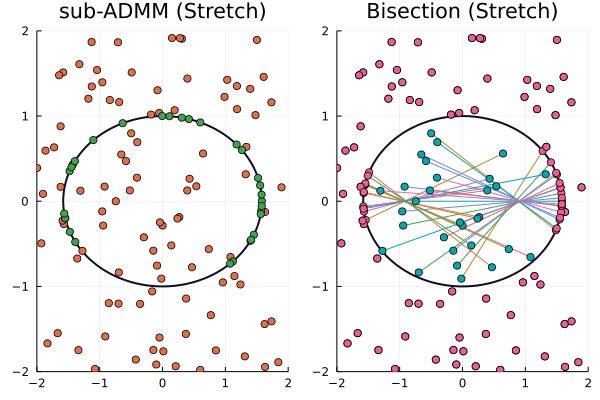

In [18]:
## Stretch Test (Vectorized)

A = diagm([2.5, 1.])
ϕ = J(Xg, A)

# W = [0.1 0.2 0.3 0.4 0.5 0.6 0.7; 
#      0.1 0.2 0.3 0.4 0.5 0.6 0.7]

W = 4*rand(2,100) .- [2.; 2]

## Alternating Direction Multipliers Method 

tick()
πCW = stretch_ADMM(W, A)
println("ADMM Stretch took ", tok(), " seconds");

p1 = contour(xig, xig, ϕ, levels=[0], colorbar=false, lw=2, xlims=(-2,2), ylims=(-2,2))
# for i = 1:size(W)[2]
#     plot!([W[1,i], πCW[1,i]], [W[2,i], πCW[2,i]], label="")
# end
scatter!(W[1,:], W[2,:], label="")
scatter!(πCW[1,:], πCW[2,:], label="")
title!("sub-ADMM (Stretch)")

## Bisection Method 

tick()
πCW = stretch_BM(W, A)
println("BM Stretch took ", tok(), " seconds");

p2 = contour(xig, xig, ϕ, levels=[0], colorbar=false, lw=2, xlims=(-2,2), ylims=(-2,2))
for i = 1:size(W)[2]
    plot!([W[1,i], πCW[1,i]], [W[2,i], πCW[2,i]], label="")
end
scatter!(W[1,:], W[2,:], label="")
scatter!(πCW[1,:], πCW[2,:], label="")
title!("Bisection (Stretch)")

plot(p1, p2)

In [15]:
## Bisection NAN check

d = 10
N = 500

A = diagm(vcat([2.5, 1.], ones(d-2)))
W = 6*rand(d,N) .- 3*ones(d)

πCW = shrink_BM(W, A)
println("NaNs in shrink:", sum(isnan.(πCW)))

πCW = stretch_BM(W, A)
println("NaNs in stretch:", sum(isnan.(πCW)))


NaNs in shrink:0
NaNs in stretch:0


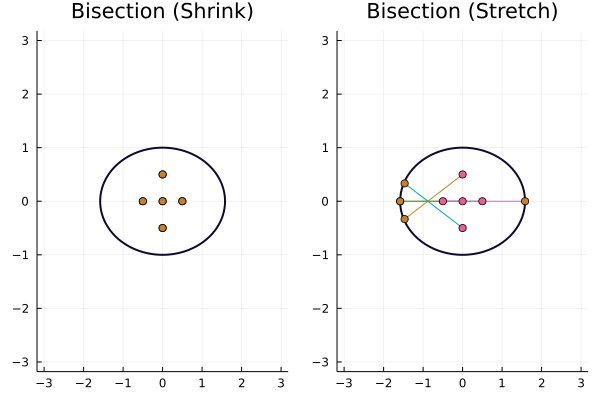

In [16]:
## Robustness Testing

ϵ = 1e-3

d = 2
A = diagm(vcat([2.5, 1.], ones(d-2)))
W = [0. 1 -1 0 0; 0 0 0 1 -1]/2 #.+ 0.5e-9*rand(d)

πCW = shrink_BM(W, A)

p1 = contour(xig, xig, ϕ, levels=[0], colorbar=false, lw=2)
for i = 1:size(W)[2]
    plot!([W[1,i], πCW[1,i]], [W[2,i], πCW[2,i]], label="")
end
scatter!(W[1,:], W[2,:], label="")
scatter!(πCW[1,:], πCW[2,:], label="")
title!("Bisection (Shrink)")

πCW = stretch_BM(W, A)

p2 = contour(xig, xig, ϕ, levels=[0], colorbar=false, lw=2)
for i = 1:size(W)[2]
    plot!([W[1,i], πCW[1,i]], [W[2,i], πCW[2,i]], label="")
end
scatter!(W[1,:], W[2,:], label="")
scatter!(πCW[1,:], πCW[2,:], label="")
title!("Bisection (Stretch)")

plot(p1, p2)

https://www.geometrictools.com/Documentation/DistancePointEllipseEllipsoid.pdf

Note, the robustness perturbation I have included at the moment is fast, but it may not lead to suitable behavior when near the origin, given that the super ADMM algorithm should be converging to an undefined point.

YDO take the mean of the argmins in this case (often yielding 0). Will have to see if it makes a difference.